In [1]:
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.3f}'.format
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
from scipy import stats

from env import get_db_url
import acquire

In [2]:
sql_all = acquire.sql_all

In [3]:
zillow = acquire.get_data_from_sql(sql_all)

In [4]:
zillow.columns.tolist()

['parcelid',
 'id',
 'airconditioningtypeid',
 'architecturalstyletypeid',
 'basementsqft',
 'bathroomcnt',
 'bedroomcnt',
 'buildingclasstypeid',
 'buildingqualitytypeid',
 'calculatedbathnbr',
 'decktypeid',
 'finishedfloor1squarefeet',
 'calculatedfinishedsquarefeet',
 'finishedsquarefeet12',
 'finishedsquarefeet13',
 'finishedsquarefeet15',
 'finishedsquarefeet50',
 'finishedsquarefeet6',
 'fips',
 'fireplacecnt',
 'fullbathcnt',
 'garagecarcnt',
 'garagetotalsqft',
 'hashottuborspa',
 'heatingorsystemtypeid',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'poolcnt',
 'poolsizesum',
 'pooltypeid10',
 'pooltypeid2',
 'pooltypeid7',
 'propertycountylandusecode',
 'propertylandusetypeid',
 'propertyzoningdesc',
 'rawcensustractandblock',
 'regionidcity',
 'regionidcounty',
 'regionidneighborhood',
 'regionidzip',
 'roomcnt',
 'storytypeid',
 'threequarterbathnbr',
 'typeconstructiontypeid',
 'unitcnt',
 'yardbuildingsqft17',
 'yardbuildingsqft26',
 'yearbuilt',
 'numberofstories',


In [5]:
zillow.calculatedfinishedsquarefeet.isna().sum()

24

In [6]:
# Drop all rows with nan sq_ft
zillow = zillow.dropna(subset=['calculatedfinishedsquarefeet'])

In [7]:
zillow.calculatedfinishedsquarefeet.isna().sum()

0

In [8]:
# Replace NaNs with 0
zillow = zillow.fillna(0)

In [9]:
# Consolidate extra features like fireplace, basement, pool etc into one column
zillow['is_extra'] = np.where(zillow.basementsqft > 0, '1',
                              np.where(zillow.fireplaceflag > 0, '1',
                                       np.where(zillow.poolcnt > 0, '1',
                                                np.where(zillow.decktypeid > 0, '1',
                                                         np.where(zillow.hashottuborspa > 0, '1',
                                                                  np.where(zillow.garagecarcnt > 0, '1',
                                                                           np.where(zillow.airconditioningtypeid > 0, '1','0')))))))

In [10]:
zillow.is_extra.value_counts(), 

(1    9572
 0    5440
 Name: is_extra, dtype: int64,)

In [11]:
zillow.head()

,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id,logerror,transactiondate,is_extra
0,11289917,2061546,1.000,0.000,0.000,2.000,3.000,0,6.000,2.000,...,2016.000,27214.000,2319.900,Y,15.000,60379005013002.000,1248,-0.362,2017-06-23,1
1,11705026,1834372,0.000,0.000,0.000,1.000,2.000,0,6.000,1.000,...,2016.000,23624.000,543.690,0,0.000,60372322001007.000,1772,-0.146,2017-06-30,0
2,14269464,1923117,0.000,0.000,0.000,3.000,4.000,0,0.000,3.000,...,2016.000,445569.000,9819.720,0,0.000,60590639072031.000,2028,0.021,2017-06-01,1
3,11389003,2121349,0.000,0.000,0.000,2.000,3.000,0,6.000,2.000,...,2016.000,449000.000,7673.190,0,0.000,60377030021015.000,3273,-0.325,2017-06-01,0
4,11967869,2093710,0.000,0.000,0.000,1.000,2.000,0,5.000,1.000,...,2016.000,191821.000,3267.470,0,0.000,60371851001001.000,3429,-0.006,2017-06-29,0


In [12]:
# Drop columns I replaced with consolidation
zillow = zillow.drop(columns=[
    'airconditioningtypeid', 'basementsqft', 'fireplaceflag', 'fireplacecnt', 'poolcnt', 
    'decktypeid', 'hashottuborspa', 'garagecarcnt', 'garagetotalsqft', 
    'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7'
                             ])

# Drop columns I can't use
zillow = zillow.drop(columns=[
    'architecturalstyletypeid', 'id', 'buildingclasstypeid', 'buildingqualitytypeid', 'calculatedbathnbr',
    'assessmentyear', 'taxdelinquencyflag', 'taxdelinquencyyear', 'censustractandblock', 'logerror', 
    'finishedfloor1squarefeet', 'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
    'finishedsquarefeet50', 'finishedsquarefeet6', 'fullbathcnt', 'heatingorsystemtypeid',
    'latitude', 'longitude', 'propertycountylandusecode', 'propertylandusetypeid', 'propertyzoningdesc',
    'rawcensustractandblock','storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid', 'unitcnt',
    'yardbuildingsqft17', 'yardbuildingsqft26', 'transactiondate', 'regionidcity', 'regionidcounty', 'regionidzip', 
                             ])

In [13]:
zillow.head()

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,lotsizesquarefeet,regionidneighborhood,roomcnt,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,is_extra
0,11289917,2.000,3.000,1458.000,6037.000,8284.000,0.000,0.000,1970.000,0.000,108890.000,136104.000,27214.000,2319.900,1
1,11705026,1.000,2.000,1421.000,6037.000,6707.000,118208.000,0.000,1911.000,0.000,11982.000,35606.000,23624.000,543.690,0
2,14269464,3.000,4.000,2541.000,6059.000,4975.000,0.000,0.000,2003.000,0.000,434887.000,880456.000,445569.000,9819.720,1
3,11389003,2.000,3.000,1650.000,6037.000,7300.000,0.000,0.000,1949.000,0.000,165000.000,614000.000,449000.000,7673.190,0
4,11967869,1.000,2.000,693.000,6037.000,2908.000,116774.000,0.000,1921.000,0.000,82416.000,274237.000,191821.000,3267.470,0


In [14]:
zillow.fips.value_counts()

6037.000    9621
6059.000    4096
6111.000    1295
Name: fips, dtype: int64

In [15]:
# Change the fips column per specs
zillow.fips = zillow.fips.astype(int)
zillow['county'] = np.where(zillow.fips == 6037, 'Los_Angeles',
                           np.where(zillow.fips == 6059, 'Orange', 
                                   'Ventura'))
zillow['state'] = 'CA'

In [16]:
# Make new categorical columns for what county properties are located in
zillow['is_LA'] = np.where(zillow.fips == 6037, '1', '0')
zillow['is_Or'] = np.where(zillow.fips == 6059, '1', '0')
zillow['is_Ven'] = np.where(zillow.fips == 6111, '1', '0')

In [17]:
# Drop the fips column, as it has outlived its usefulness
zillow = zillow.drop(columns='fips')

In [18]:
# Add tax rate column per specs, and drop tax columns from data (because cheating)
zillow['tax_rate'] = (zillow.taxamount / zillow.taxvaluedollarcnt).round(4)
zillow = zillow.drop(columns=['structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount'])

In [19]:
# Because my model had such low correlation between bedroom and bathroom counts,
# I'm going to add them together and make a new column
zillow['bath_bed'] = zillow.bathroomcnt + zillow.bedroomcnt

In [20]:
# Calulate the age of the property
zillow['age'] = 2017 - zillow.yearbuilt

In [21]:
# Calulate ratio of home size to lot size
zillow['size_ratio'] = (zillow.calculatedfinishedsquarefeet / zillow.lotsizesquarefeet).round(4)

In [22]:
zillow.head()

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,lotsizesquarefeet,regionidneighborhood,roomcnt,yearbuilt,numberofstories,taxvaluedollarcnt,is_extra,county,state,is_LA,is_Or,is_Ven,tax_rate,bath_bed,age,size_ratio
0,11289917,2.000,3.000,1458.000,8284.000,0.000,0.000,1970.000,0.000,136104.000,1,Los_Angeles,CA,1,0,0,0.017,5.000,47.000,0.176
1,11705026,1.000,2.000,1421.000,6707.000,118208.000,0.000,1911.000,0.000,35606.000,0,Los_Angeles,CA,1,0,0,0.015,3.000,106.000,0.212
2,14269464,3.000,4.000,2541.000,4975.000,0.000,0.000,2003.000,0.000,880456.000,1,Orange,CA,0,1,0,0.011,7.000,14.000,0.511
3,11389003,2.000,3.000,1650.000,7300.000,0.000,0.000,1949.000,0.000,614000.000,0,Los_Angeles,CA,1,0,0,0.013,5.000,68.000,0.226
4,11967869,1.000,2.000,693.000,2908.000,116774.000,0.000,1921.000,0.000,274237.000,0,Los_Angeles,CA,1,0,0,0.012,3.000,96.000,0.238


In [23]:
zillow.numberofstories.value_counts()

0.000    10818
1.000     2532
2.000     1567
3.000       95
Name: numberofstories, dtype: int64

In [24]:
# Replace 0s in numberofstories with 1
zillow.numberofstories = zillow.numberofstories.replace([0], 1)

In [25]:
# I want to proxy the value amount, without using it. 
# maybe i can try weird math to come up with a way to substitute it with sq_feet and neighborhoods
# divide avg sq feet of a neighborhood by (number of houses / avg sq feet) 
thing = pd.DataFrame(zillow.regionidneighborhood.value_counts())
thing = thing.rename(columns={'regionidneighborhood': 'num_houses'})
thing['avg_value'] = zillow.groupby('regionidneighborhood')['taxvaluedollarcnt'].agg('median')
thing['avg_sq_ft'] = zillow.groupby('regionidneighborhood')['calculatedfinishedsquarefeet'].agg('median')
thing['factor'] = thing.avg_sq_ft / (thing.num_houses / thing.avg_sq_ft)
thing['divisor'] = thing.num_houses / thing.avg_sq_ft

thing.head()

,num_houses,avg_value,avg_sq_ft,factor,divisor
0.000,9515,369129.000,1717.000,309.836,5.542
48570.000,138,547550.000,2115.000,32414.674,0.065
27080.000,133,720827.000,1816.000,24795.910,0.073
118208.000,121,181221.000,1242.000,12748.463,0.097
113455.000,113,513716.000,2047.000,37081.496,0.055


In [26]:
zillow = zillow.merge(thing[['factor', 'divisor']], left_on='regionidneighborhood', right_index=True).reset_index()
zillow['sq_feet_proxy'] = zillow.size_ratio * zillow.factor
zillow['sq_feet_proxy2'] = zillow.size_ratio / zillow.factor
zillow['sq_feet_proxy3'] = zillow.size_ratio * zillow.divisor
zillow['sq_feet_proxy4'] = zillow.size_ratio / zillow.divisor
zillow['sq_feet_proxy5'] = zillow.calculatedfinishedsquarefeet * zillow.factor
zillow['sq_feet_proxy6'] = zillow.calculatedfinishedsquarefeet / zillow.factor
zillow['sq_feet_proxy7'] = zillow.calculatedfinishedsquarefeet * zillow.divisor
zillow['sq_feet_proxy8'] = zillow.calculatedfinishedsquarefeet / zillow.divisor

zillow.head()

,index,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,lotsizesquarefeet,regionidneighborhood,roomcnt,yearbuilt,numberofstories,...,factor,divisor,sq_feet_proxy,sq_feet_proxy2,sq_feet_proxy3,sq_feet_proxy4,sq_feet_proxy5,sq_feet_proxy6,sq_feet_proxy7,sq_feet_proxy8
0,0,11289917,2.000,3.000,1458.000,8284.000,0.000,0.000,1970.000,1.000,...,309.836,5.542,54.531,0.001,0.975,0.032,451740.805,4.706,8079.715,263.099
1,2,14269464,3.000,4.000,2541.000,4975.000,0.000,0.000,2003.000,1.000,...,309.836,5.542,158.264,0.002,2.831,0.092,787293.132,8.201,14081.313,458.528
2,3,11389003,2.000,3.000,1650.000,7300.000,0.000,0.000,1949.000,1.000,...,309.836,5.542,70.023,0.001,1.252,0.041,511229.306,5.325,9143.710,297.746
3,6,14236060,2.000,3.000,1668.000,6774.000,0.000,7.000,1976.000,1.000,...,309.836,5.542,76.282,0.001,1.364,0.044,516806.353,5.383,9243.460,300.994
4,7,14365030,2.500,3.000,1653.000,3090.000,0.000,0.000,1992.000,1.000,...,309.836,5.542,165.762,0.002,2.965,0.097,512158.814,5.335,9160.335,298.287


In [27]:
#Drop neighborhood column
zillow = zillow.drop(columns=['regionidneighborhood'])

In [28]:
# Rename columns to be more friendly
zillow = zillow.rename(columns={
    "calculatedfinishedsquarefeet": "home_sf",
    "lotsizesquarefeet": "lot_sf",
    "numberofstories": "stories",
    "taxvaluedollarcnt": "value",
})

In [29]:
zillow.head()

,index,parcelid,bathroomcnt,bedroomcnt,home_sf,lot_sf,roomcnt,yearbuilt,stories,value,...,factor,divisor,sq_feet_proxy,sq_feet_proxy2,sq_feet_proxy3,sq_feet_proxy4,sq_feet_proxy5,sq_feet_proxy6,sq_feet_proxy7,sq_feet_proxy8
0,0,11289917,2.000,3.000,1458.000,8284.000,0.000,1970.000,1.000,136104.000,...,309.836,5.542,54.531,0.001,0.975,0.032,451740.805,4.706,8079.715,263.099
1,2,14269464,3.000,4.000,2541.000,4975.000,0.000,2003.000,1.000,880456.000,...,309.836,5.542,158.264,0.002,2.831,0.092,787293.132,8.201,14081.313,458.528
2,3,11389003,2.000,3.000,1650.000,7300.000,0.000,1949.000,1.000,614000.000,...,309.836,5.542,70.023,0.001,1.252,0.041,511229.306,5.325,9143.710,297.746
3,6,14236060,2.000,3.000,1668.000,6774.000,7.000,1976.000,1.000,196483.000,...,309.836,5.542,76.282,0.001,1.364,0.044,516806.353,5.383,9243.460,300.994
4,7,14365030,2.500,3.000,1653.000,3090.000,0.000,1992.000,1.000,605000.000,...,309.836,5.542,165.762,0.002,2.965,0.097,512158.814,5.335,9160.335,298.287


(24.0, 0.0)

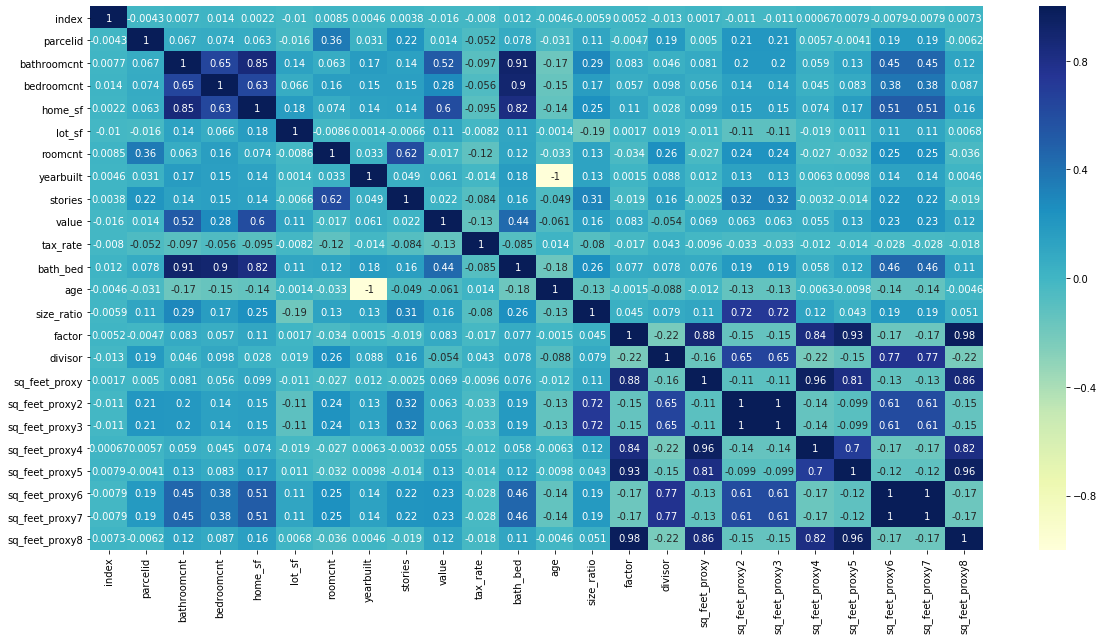

In [30]:
# Now lets see how these columns correlate
plt.figure(figsize=(20,10))
corr = zillow.corr()
ax = sns.heatmap(corr, annot=True, cmap="YlGnBu")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [31]:
# Looking at the value column, it looks like bathroomcnt, home_sf are well correlated. 
# sq_feet_proxy6 & 7 are almost as good as bedroomcnt! I'll keep just one
# The engineered column bath_bed is better correlated than most,
# but not as well as just bathroom count, so I'll drop it
# Same for the engineered column size_ratio, but since it is better correlated than lot_sf, 
# I'll leave it and drop lot_sf

# Negatively correlated columns will be dropped:
# roomcnt, yearbuilt, tax_rate
# Low correlation columns will be dropped:
# stories, age

In [32]:
# Run t-test between value and categorical variables
# is_extra, is_LA, is_Or, is_Ven
# As the difference between the sample data and the null hypothesis increases,
# the absolute value of the t-value increases. So, higher t stat is better

In [33]:
x1 = zillow[zillow.is_extra == '1'].value
x2 = zillow[zillow.is_extra == '0'].value

stats.ttest_ind(x1, x2)

Ttest_indResult(statistic=21.048729069772993, pvalue=5.884527597826207e-97)

In [34]:
x1 = zillow[zillow.is_LA == '1'].value
x2 = zillow[zillow.is_LA == '0'].value

stats.ttest_ind(x1, x2)

Ttest_indResult(statistic=-6.053751038296455, pvalue=1.4488179027543395e-09)

In [35]:
x1 = zillow[zillow.is_Or == '1'].value
x2 = zillow[zillow.is_Or == '0'].value

stats.ttest_ind(x1, x2)

Ttest_indResult(statistic=7.819962092586674, pvalue=5.633905231174361e-15)

In [36]:
x1 = zillow[zillow.is_Ven == '1'].value
x2 = zillow[zillow.is_Ven == '0'].value

stats.ttest_ind(x1, x2)

Ttest_indResult(statistic=-2.049882354512452, pvalue=0.040393248999228235)

In [37]:
# it looks like is_extra is the best of all, and location isn't very relevant.

In [38]:
# Remaining columns for model:
# y = value
# X = home_sf, bathroomcnt, bedroomcnt, size_ratio, is_extra, sq_feet_proxy6

In [47]:
# Test new wrangle_zillow_FE function
sql_FE = acquire.sql_FE
zillow_FE = acquire.wrangle_zillow_FE(sql_FE)
zillow_FE = zillow_FE.merge(thing[['factor']], left_on='neighborhood', right_index=True).reset_index()
zillow_FE['sq_feet_proxy6'] = zillow_FE.home_sf / zillow_FE.factor

zillow_FE.head()

,index,parcelid,neighborhood,value,baths,beds,home_sf,is_extra,county,state,tax_rate,size_ratio,factor,sq_feet_proxy6
0,0,11289917,0,136104,2.000,3,1458,1,Los_Angeles,CA,0.017,0.176,309.836,4.706
1,2,14269464,0,880456,3.000,4,2541,0,Orange,CA,0.011,0.511,309.836,8.201
2,3,11389003,0,614000,2.000,3,1650,0,Los_Angeles,CA,0.013,0.226,309.836,5.325
3,6,14236060,0,196483,2.000,3,1668,0,Orange,CA,0.012,0.246,309.836,5.383
4,7,14365030,0,605000,2.500,3,1653,0,Orange,CA,0.010,0.535,309.836,5.335


In [48]:
zillow_FE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14912 entries, 0 to 14911
Data columns (total 14 columns):
index             14912 non-null int64
parcelid          14912 non-null int64
neighborhood      14912 non-null int64
value             14912 non-null int64
baths             14912 non-null float64
beds              14912 non-null int64
home_sf           14912 non-null int64
is_extra          14912 non-null object
county            14912 non-null object
state             14912 non-null object
tax_rate          14912 non-null float64
size_ratio        14912 non-null float64
factor            14912 non-null float64
sq_feet_proxy6    14912 non-null float64
dtypes: float64(5), int64(6), object(3)
memory usage: 1.6+ MB


In [49]:
zillow_FE.neighborhood.value_counts()

0         9461
48570      138
27080      130
118208     121
113455     113
          ... 
761215       1
761223       1
267814       1
761543       1
416303       1
Name: neighborhood, Length: 370, dtype: int64

In [50]:
pd.set_option('use_inf_as_na', True)

In [51]:
zillow_FE.isna().sum()

index             0
parcelid          0
neighborhood      0
value             0
baths             0
beds              0
home_sf           0
is_extra          0
county            0
state             0
tax_rate          0
size_ratio        0
factor            0
sq_feet_proxy6    0
dtype: int64

In [52]:
np.isinf(zillow_FE.size_ratio).sum()

0

In [53]:
# Save zillow_FE as csv
zillow_FE.to_csv('zillow_FE.csv')